File dove eseguire vari test tra due sequenze modificate

In [1]:
from transformers import BertForSequenceClassification, DNATokenizer
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
from utils.utils import *

/home/jovoni/anaconda3/envs/dnabert/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def feed_tokenizer(s, tokenizer):
    out = tokenizer.encode(
                        s,
                        add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                        padding = 'longest',        # Pad to longest in batch.
                        truncation = True,          # Truncate sentences to `max_length`.
                        max_length = 512,   
                        return_attention_mask = True, # Construct attn. masks.
                        return_tensors = 'pt',        # Return pytorch tensors.
                )
    return out

def obtain_embeddings(s, model, tokenizer):
    tokenizer_output = feed_tokenizer(s, tokenizer)
    model_output = model(tokenizer_output)
    hidden_states = model_output[1]

    # Create tensor of embeddings
    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = token_embeddings.squeeze()
    return token_embeddings.detach().numpy()

def obtain_cls_embeddings(s, model, tokenizer, layer_list):
    tokenizer_output = feed_tokenizer(s, tokenizer)
    model_output = model(tokenizer_output)
    hidden_states = model_output[1]
    
    words_encoding = torch.cat([hidden_states[i][0] for i in layer_list],dim=1)
    sentence_embedding = torch.mean(words_encoding, dim=0)
    return sentence_embedding.detach().numpy()

def obtain_attentions(s, model, tokenizer):
    tokenizer_output = feed_tokenizer(s, tokenizer)
    model_output = model(tokenizer_output)
    attention = model_output[2]
    attention = torch.stack(attention)
    return attention.squeeze().detach().numpy()
    
def extract_sentence_vector(emb, layer, dim):
    token_vecs = emb[layer]
    sentence_embedding = torch.mean(token_vecs, dim=dim)
    return sentence_embedding

def cos(x, y):
    return x.dot(y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [3]:
# Info
model_path = "dnabert6/"

# Load config, model and tokenizer
tokenizer = DNATokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path, 
                                                    output_attentions=True,
                                                    output_hidden_states=True)

<class 'transformers.tokenization_dna.DNATokenizer'>


In [4]:
# Read two Sequences
n = 11
df = pd.read_csv("dataset/same_sequence/all_data_0.csv", sep=";")
row = df.iloc[n]
print(row)
s1 = row.ORIGINAL_SEQ
s2 = row.NEW_SEQ
use_s3 = False
if len(s2) > 512:
    s3 = s2[512:]
    s2 = s2[:512]
    use_s3 = True
sv_type = row.SV_TYPE

s1 = get_kmer_sentence(s1, 6)
s2 = get_kmer_sentence(s2, 6)
if use_s3:
    s3 = get_kmer_sentence(s3, 6)

ORIGINAL_SEQ    GAAGTGGTTTCACAATGTCCCTCAACGTGTGACTATCACCCATAGC...
SV_TYPE                                                         4
BP_1                                                          134
BP_2                                                          246
NEW_SEQ         GAAGTGGTTTCACAATGTCCCTCAACGTGTGACTATCACCCATAGC...
CHR_NAME                                                    chr21
Name: 11, dtype: object


In [5]:
# produce sequence
file_name = "data/chromosomes/chr21.fa"
s = extract_sequence(file_name, 2)

In [6]:
# apply
s1 = s[0]
s2, b1, b2, lenght = DUP(s1)
#s2, b1_, b2_, length_ = INV(s2)
s2, indexes_modified = small_variants(s2, 0)

# divide in kmer
other_seq = preprocess_sequence(s[1])
s1 = preprocess_sequence(s1)
s2 = preprocess_sequence(s2)

print(len(s[0]))
print(b1, b2)
#print(b1_, b2_)
print(indexes_modified)

237
36 95
[]


### EMBEDDINGS

In [7]:
# Turn into embeddings
embeddings1 = obtain_embeddings(s1, model, tokenizer)
embeddings2 = obtain_embeddings(s2, model, tokenizer)
embeddings_other = obtain_embeddings(other_seq, model, tokenizer)
if use_s3:
    embeddings3 = obtain_embeddings(s3, model, tokenizer)

In [20]:
scores_mat = []
use_other = False
for layer in tqdm(range(13)):
    tok_vec_1 = embeddings1[layer]
    if use_other:
        tok_vec_2 = embeddings_other[layer]
    else:
        tok_vec_2 = embeddings2[layer]
    if use_s3:
        tok_vec_3 = embeddings3[layer]
        tok_vec_2 = np.concatenate((tok_vec_2, tok_vec_3))
    mat = np.zeros((tok_vec_1.shape[0], tok_vec_2.shape[0]))
    for i, x in enumerate(tok_vec_1):
        for j, y in enumerate(tok_vec_2):
            mat[i,j] = cos(x, y)
            #mat[i,j] = x.dot(y)

    scores_mat.append(mat)

100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


In [60]:
def get_tilde_representations(a, b, scores, layer):
    E = scores[layer]
        
    l_a = len(a)
    l_b = len(b)
    
    A_tilde = np.empty((l_a, l_b))
    B_tilde = np.empty((l_b, l_a))
     
    for i in range(l_a):
        e_i = E[i]
        e_i_exp = np.exp(e_i)
        e_i_norm = e_i_exp / np.sum(e_i_exp)
        A_tilde[i] = np.sum((b.T * e_i_norm).T, axis=1)
        
    for i in range(l_b):
        e_i = E[:,i]
        e_i_exp = np.exp(e_i)
        e_i_norm = e_i_exp / np.sum(e_i_exp)
        B_tilde[i] = np.sum((a.T * e_i_norm).T, axis=1)
        
    return A_tilde, B_tilde

In [74]:
# Bert-based Siamese Network for Semantic Similarity
# compute correlation with each word
a = tok_vec_1
b = tok_vec_2
layer = -1

A_tilde, B_tilde = get_tilde_representations(a, b, scores_mat, layer)

# Perform pooling
v_a_bar = np.max(a, axis=0)
v_b_bar = np.max(b, axis=0)

v_a_tilde = np.max(A_tilde, axis=1)
v_b_tilde = np.max(B_tilde, axis=1)


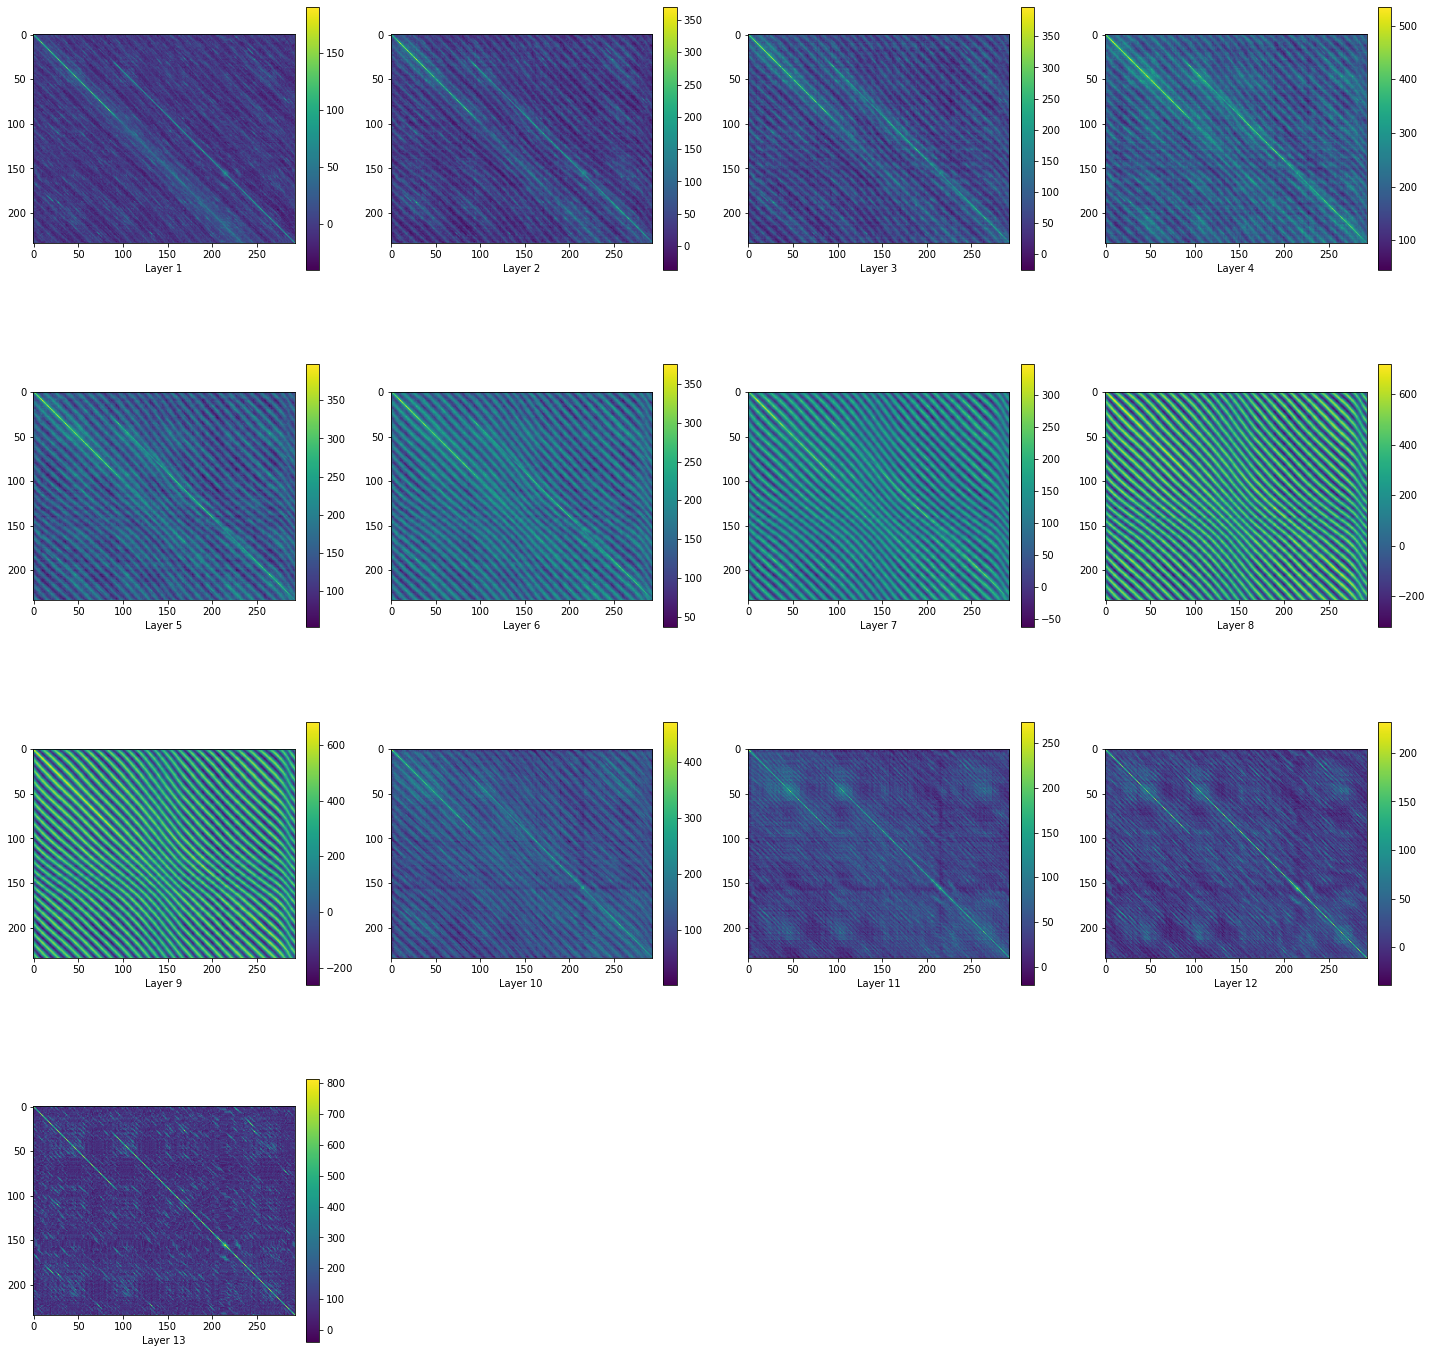

In [9]:
fig = plt.figure(figsize=(20, 20))

show_high_values = False

for idx, scores in enumerate(scores_mat):
    scores_np = np.array(scores)
    
    if show_high_values:
        min_v, max_v = np.min(scores_np), np.max(scores_np)
        delta = max_v - min_v
        threshold = min_v + delta * 0.8
        scores_np = np.where(scores_np >= threshold, scores_np, min_v)
    
    ax = fig.add_subplot(4, 4, idx+1)
    # append the attention weights
    im = ax.imshow(scores_np, cmap='viridis')

    fontdict = {'fontsize': 10}

    ax.set_xlabel(f'Layer {idx+1}')

    fig.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [86]:
scores_mat_perturbed = []
use_other = False
for layer in tqdm(range(13)):
    tok_vec_1 = embeddings1[layer]
    if use_other:
        tok_vec_2 = embeddings_other[layer]
    else:
        tok_vec_2 = embeddings2[layer]
    if use_s3:
        tok_vec_3 = embeddings3[layer]
        tok_vec_2 = np.concatenate((tok_vec_2, tok_vec_3))
    mat = np.zeros((tok_vec_1.shape[0], tok_vec_2.shape[0]))
    for i, x in enumerate(tok_vec_1):
        for j, y in enumerate(tok_vec_2):
            #mat[i,j] = cos(x, y)
            mat[i,j] = x.dot(y)

    scores_mat_perturbed.append(mat)
    
scores_mat_unperturbed = []
use_other = False
for layer in tqdm(range(13)):
    tok_vec_1 = embeddings1[layer]
    tok_vec_2 = embeddings1[layer]
    mat = np.zeros((tok_vec_1.shape[0], tok_vec_2.shape[0]))
    for i, x in enumerate(tok_vec_1):
        for j, y in enumerate(tok_vec_2):
            #mat[i,j] = cos(x, y)
            mat[i,j] = x.dot(y)

    scores_mat_unperturbed.append(mat)

100%|██████████| 13/13 [00:01<00:00,  7.76it/s]


In [87]:
diff_mat = [abs(m1 - m2) for m1, m2 in zip(scores_mat_perturbed, scores_mat_unperturbed)]

fig = plt.figure(figsize=(20, 20))

show_high_values = False

for idx, scores in enumerate(diff_mat):
    scores_np = np.array(scores)
    
    if show_high_values:
        min_v, max_v = np.min(scores_np), np.max(scores_np)
        delta = max_v - min_v
        threshold = min_v + delta * 0.8
        scores_np = np.where(scores_np >= threshold, scores_np, min_v)
    
    ax = fig.add_subplot(4, 4, idx+1)
    # append the attention weights
    im = ax.imshow(scores_np, cmap='viridis')

    fontdict = {'fontsize': 10}

    ax.set_xlabel(f'Layer {idx+1}')

    fig.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

ValueError: operands could not be broadcast together with shapes (332,416) (332,332) 

### ATTENTION

In [76]:
def plot_attention_score(s, model, tokenizer):
    attention = obtain_attentions(s, model, tokenizer)
    n = len(s.split())
    
    attn_score_1 = np.zeros((12, n))
    for i in range(12):
        for t in range(n):
            attn_score_1[i][t] = float(attention[i,:,t,:].sum())
            
    fig = plt.figure(figsize=(20, 20))
    plt.imshow(attn_score_1)
    plt.show()

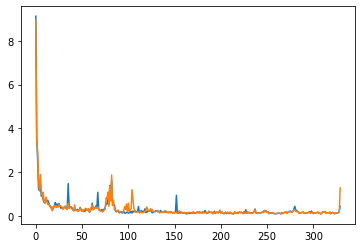

In [78]:
attention_1 = obtain_attentions(s1, model, tokenizer)
attention_2 = obtain_attentions(s2, model, tokenizer)

attn_score_1 = []
attn_score_2 = []

N = len(s1.split()) + 2
for i in range(1, N-1):
    attn_score_1.append(float(attention_1[:,:,0,i].sum()))
    
N = len(s2.split()) + 2
for i in range(1, N-1):
    attn_score_2.append(float(attention_2[:,:,0,i].sum()))  
    
plt.plot(attn_score_1)
plt.plot(attn_score_2)

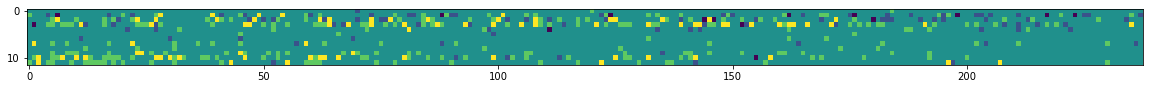

In [29]:
plot_attention_score(s1, model, tokenizer)

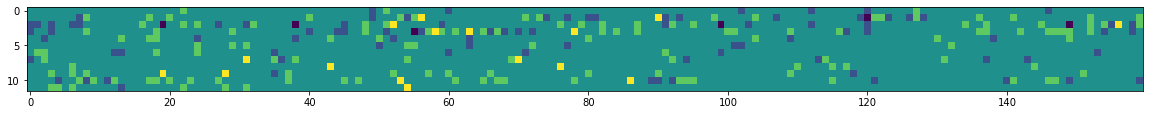

In [30]:
plot_attention_score(s2, model, tokenizer)

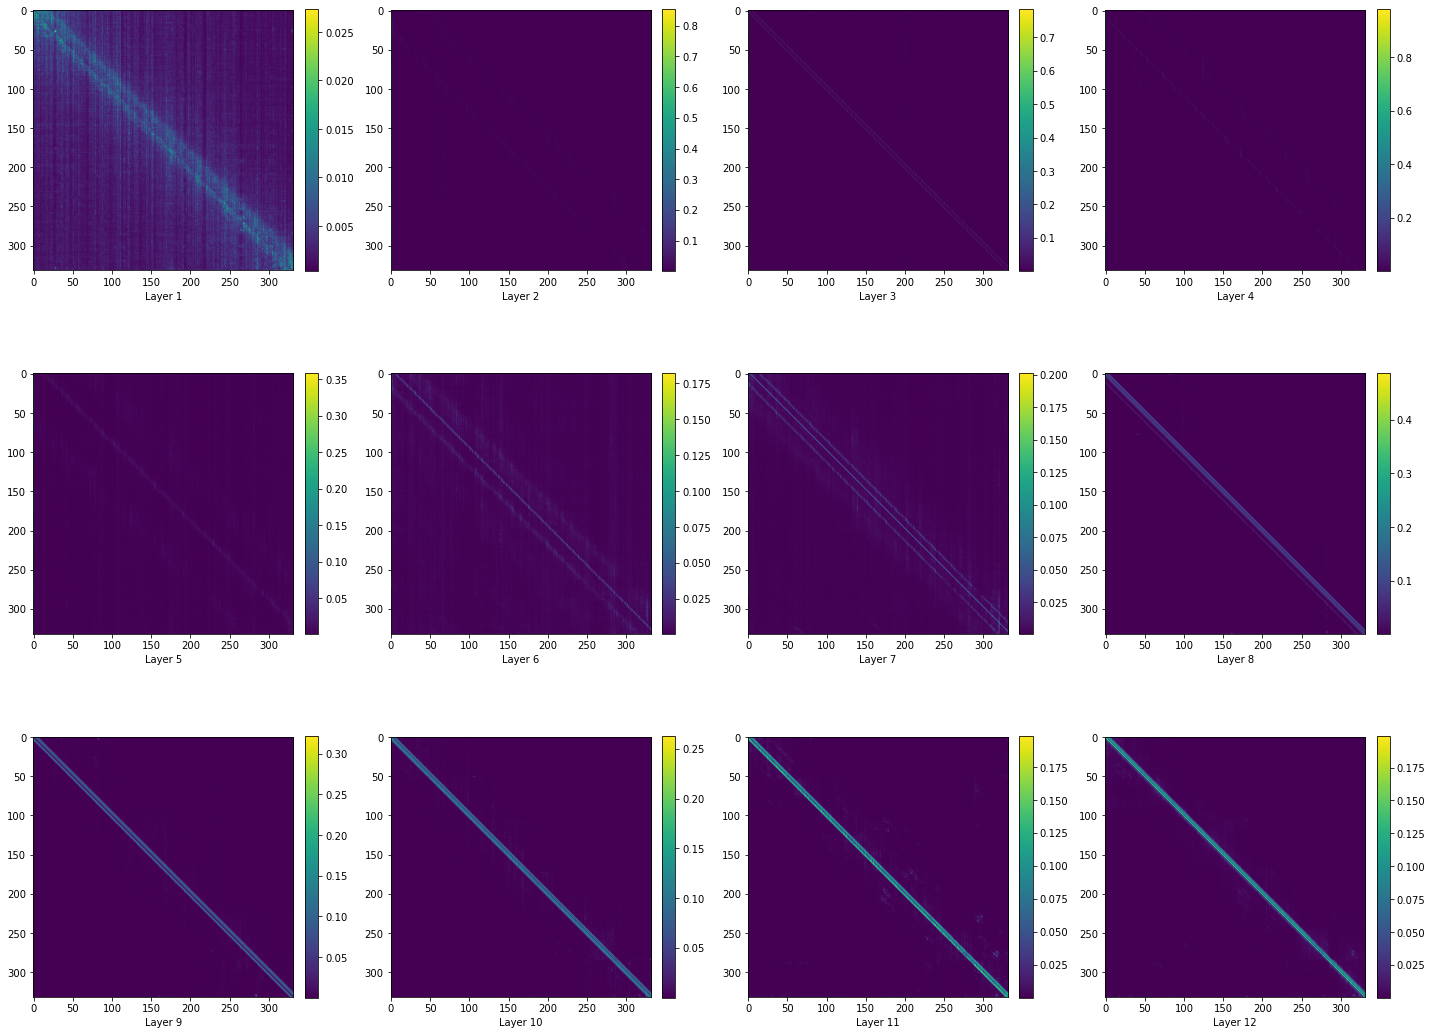

In [81]:
fig = plt.figure(figsize=(20, 20))

for idx, scores in enumerate(attention_1):
    scores_np = np.array(scores.mean(0))
    
    ax = fig.add_subplot(4, 4, idx+1)
    # append the attention weights
    im = ax.imshow(scores_np, cmap='viridis')

    fontdict = {'fontsize': 10}

    ax.set_xlabel(f'Layer {idx+1}')

    fig.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()